In [59]:
import platform
import warnings
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from matplotlib import rc
from gensim.models import Word2Vec

warnings.filterwarnings(action='ignore')


In [60]:
class check_data():
    def __init__(self,df):
        self.df = df
        self.wiki_model = Word2Vec.load('../ko/ko.bin')
        if platform.system() == 'Windows':
            self.font = 'Malgun Gothic'
        else:
            self.font = 'NanumGothic'

        self.eff = self.df.columns[1]
        self.df[f'{self.eff}_Morps'] = self.df[self.eff].map(lambda x: self.getMorps(x))
        self.df[f'{self.eff}_NV'] = self.df[f'{self.eff}_Morps'].map(lambda x: self.getNV(x))
        self.df[f'{self.eff}_N'] = self.df[f'{self.eff}_Morps'].map(lambda x: self.getN(x))
  
    def topn(self,n):
        self.df[f'{self.eff}_count_topn_NV']  = self.df[f'{self.eff}_NV'].map(lambda x: self.counter(x,n)) 
        self.df[f'{self.eff}_count_topn_N']  = self.df['{self.eff}_N'].map(lambda x: self.counter(x,n)) 

    def getMorps(self,sent):
        return Okt().pos(sent , norm=False , stem = True) 

    def getNV(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "
        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Verb' or morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        return s_result
    
    def getN(self, morps):
        stop_words = "하다 것 등 수 그 이 더욱 대해 예 머 매 내 수도 무엇 모든 이다 때 곧 식 또한 좀 꼭 번 해 과 바로 더욱 논 보이 난 "

        stop_words = set(stop_words.split(' '))

        result = []
        for item , morp in morps:
            if morp == 'Noun': 
                result.append(item)
        s_result = []
        
        for word in result:
            if word not in stop_words:
                s_result.append(word)
        s_result = np.unique(s_result)
        return s_result

    def counter(self,sents, n):
        return sorted(collections.Counter(sents),reverse=True)[0:n]

    def get_heatmap(self, idx,figsize):
        plt.rc('font', family=self.font)
        result = []
        sents = self.df[f'{self.eff}_NV'][idx]
        effs_dims = ['에너지', '회복', '순환', '정화']
        
        
        for in_word in sents:
            sub_result = []
            for out_word in effs_dims:
                try:
                    sub_result.append(3*self.wiki_model.wv.similarity(out_word, in_word)-0.3)
                except:
                    sub_result.append(0)
            result.append(sub_result)
        
        act_name = self.df['action'][idx]
        fig = plt.figure(figsize=figsize)
        fig.set_facecolor('white')
        plt.title(f'{act_name}에서 단어들간의 유사도 확인')
        sns.heatmap(result,annot=True)
        plt.xticks(np.arange(len(effs_dims)),effs_dims)
        plt.yticks(np.arange(len(sents)),sents)
        plt.show()
        
    def getDF(self):
        self.df.to_csv('data.csv')
        return self.df

    def result(self,idx, top , dis):
        effs_dims = ['에너지', '회복', '순환', '정화']
        sNV = self.df[f'{self.eff}_NV'][idx]

        result = []
        for dim in effs_dims:
            sub = []
            for word in sNV:
                try:
                    sub.append(3*self.wiki_model.wv.similarity(dim , word)-0.3)
                except:
                    sub.append(0)
            tmp = np.sort(sub)[::-1][:top].mean()
            result.append(tmp)


        if dis == True:
            from matplotlib import rc
            plt.rc('font', family=self.font)

            word = self.df.iloc[idx][0]

            plt.figure()
            plt.bar(np.arange(len(result)),result)
            plt.title(f'{word}\'s mapping for top {top} using 대표어')
            plt.xticks(np.arange(len(effs_dims)), effs_dims)
            plt.yticks(np.arange(0,1.2,0.2))
            plt.show()
        return result

    def todf(self,file_name):
        ret_df  = pd.DataFrame(columns=['감정','에너지','회복','순환','정화'])
        em = []
        est_e= []
        est_h= []
        est_c= []
        est_p= []
        
        for idx in self.df.index:
            em.append(self.df['action'][idx])
            est = self.result(idx,3,False)
            est_e.append(est[0])        
            est_h.append(est[1])        
            est_c.append(est[2])        
            est_p.append(est[3])
        ret_df['감정'] = em        
        ret_df['에너지'] = est_e
        ret_df['회복'] = est_h
        ret_df['순환'] = est_c
        ret_df['정화'] = est_p
        
        ret_df.to_csv(file_name,index=False)
        return ret_df

In [61]:
dir = "../data/action_keyword_data_세혁.csv"
data = pd.read_csv(dir)
data

,action,효능
0,여행,여유 체력 인연 전환 해결 시야 새로움 자유 취향 도전 연결 각성
1,스트레칭,완화 이완 수행 가동 예방 활성화 지각 순환 회복 개선 해소


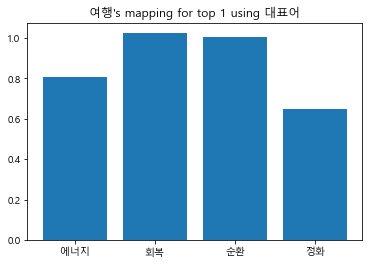

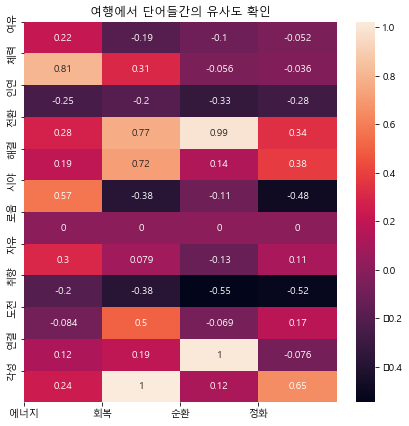

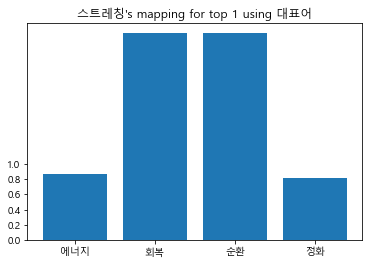

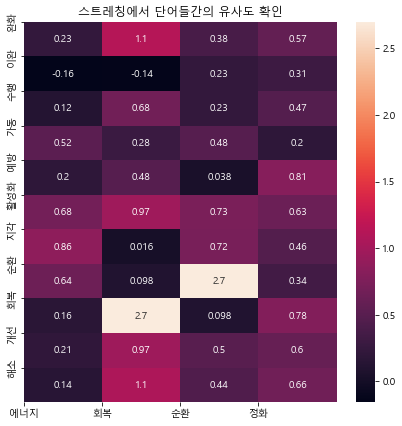

In [65]:
XYZ = check_data(data)
for i in range(0,2):
    XYZ.result(i,1,True)
    XYZ.get_heatmap(i,(7,7))

In [56]:
dir = "../data/action_keyword_data.csv"
data = pd.read_csv(dir)
data

,action,효능
0,명상,마음 긍정 정신 안정감 휴식
1,산책,기분 유연성 건강 휴식 소화
2,등산,근력 호흡 즐거움 심장 면역력
3,샤워,피부 배출 수면 활력
4,수영,근력 지구력 운동 진정 심장 활동
5,조깅,유연성 호흡 체중 조절 면역 활력 체지방
6,자전거 타기,하체 체중 다이어트 관절 활력
7,요가,유연성 균형 호흡 집중력 자세 피로
8,스트레칭,부상 피로 이완 운동 탄력 균형
9,여행,활력 해방 교류 새로움


C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


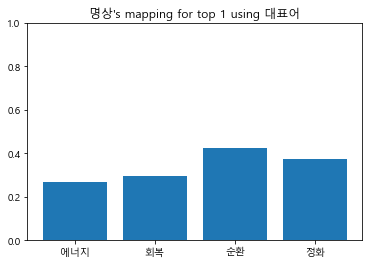

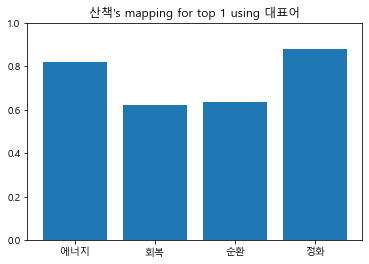

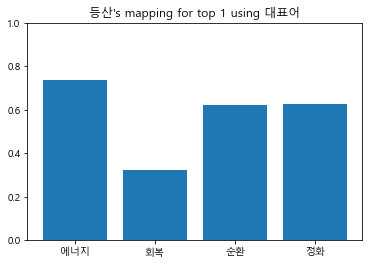

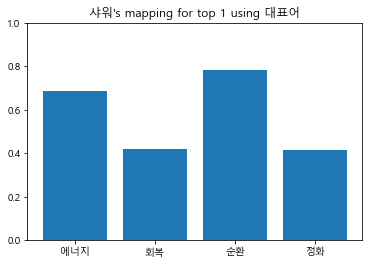

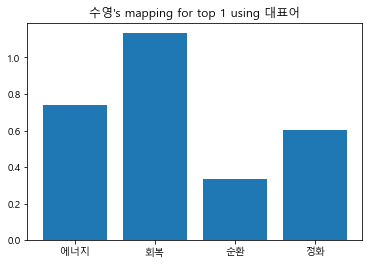

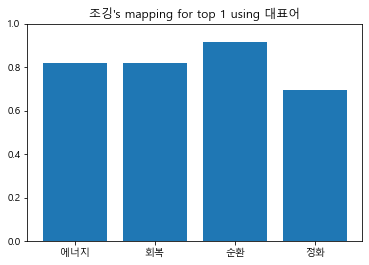

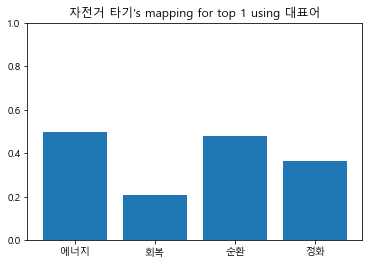

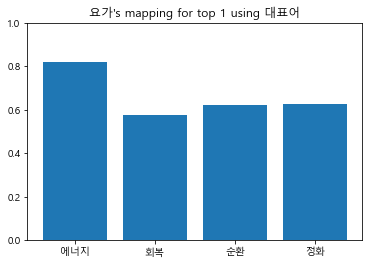

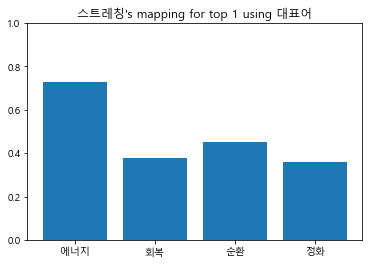

In [57]:
XYZ = check_data(data)
for i in range(0,9):
    XYZ.result(i,1,True)
    #XYZ.get_heatmap(i,(7,7))

In [58]:
XYZ = check_data(data[0:5])
data.head()
XYZ.todf("../result/action_estimation.csv")

C:\Users\fd\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(
C:\Users\fd\AppData\Local\Temp/ipykernel_12984/2277636951.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[f'{self.eff}_Morps'] = self.df[self.eff].map(lambda x: self.getMorps(x))
C:\Users\fd\AppData\Local\Temp/ipykernel_12984/2277636951.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

,감정,에너지,회복,순환,정화
0,명상,0.193222,0.176850,0.035178,0.287196
1,산책,0.558091,0.444047,0.450872,0.596212
2,등산,0.689816,0.239648,0.501124,0.350389
3,샤워,0.467012,0.043225,0.237047,0.197528
4,수영,0.529156,0.587145,0.257707,0.286786
